In [1]:
!pip install pm4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached lxml-4.9.3-cp311-cp311-manylinux_2_28_x86_64.whl (7.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 6.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 32.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 18.1 MB/s eta 0:00:0000:0100:01
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=9191f270f5c79d4ce486417d18f281ed50

In [2]:
import pm4py
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter

In [94]:
df = pd.read_csv('log-2023-11-12-10.csv', header=None, names=['date', 'patchset', 'event'])
df.head()

,date,patchset,event
0,1618924135,681367,newpatchset
1,1618924154,681367,ciSuccess
2,1618924159,681367,merge
3,1618925966,681367,ciSuccess
4,1618841240,680857,newpatchset


In [95]:
df['date'] = pd.to_datetime(df['date'], unit='s', utc=True)
df.head()

,date,patchset,event
0,2021-04-20 13:08:55+00:00,681367,newpatchset
1,2021-04-20 13:09:14+00:00,681367,ciSuccess
2,2021-04-20 13:09:19+00:00,681367,merge
3,2021-04-20 13:39:26+00:00,681367,ciSuccess
4,2021-04-19 14:07:20+00:00,680857,newpatchset


In [96]:
df = pm4py.format_dataframe(df, case_id='patchset', activity_key='event', timestamp_key='date')
df.head()

/home/thcipriani/Projects/Wikimedia/local-gerrit-docker/.venv/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/thcipriani/Projects/Wikimedia/local-gerrit-docker/.venv/lib/python3.11/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)


,date,patchset,event,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,2022-05-22 19:33:37+00:00,133222,patch,133222,patch,2022-05-22 19:33:37+00:00,0,0
1,2023-05-19 13:31:01+00:00,133222,patch,133222,patch,2023-05-19 13:31:01+00:00,1,0
2,2023-05-19 13:39:10+00:00,133222,ciFail,133222,ciFail,2023-05-19 13:39:10+00:00,2,0
3,2023-05-19 13:45:00+00:00,133222,ciSuccess,133222,ciSuccess,2023-05-19 13:45:00+00:00,3,0
4,2023-05-20 07:30:05+00:00,133222,patch,133222,patch,2023-05-20 07:30:05+00:00,4,0


In [106]:
event_log = log_converter.apply(df)
filtered_log = pm4py.filter_start_activities(event_log, ["newpatchset"])
filtered_log = pm4py.filter_end_activities(filtered_log, ['merge', 'deploy', 'abandon'])

/home/thcipriani/Projects/Wikimedia/local-gerrit-docker/.venv/lib/python3.11/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


## Let's get an idea of how long the process takes

This is the process between new patches entering gerrit and deployment

In [100]:
import numpy as np
import humanize
all_case_durations = pm4py.get_all_case_durations(filtered_log)
print('Average Lead Time: %s' % humanize.precisedelta(np.mean(all_case_durations)))
print('Median Lead Time: %s' % humanize.precisedelta(np.median(all_case_durations)))

Average Lead Time: 15 days, 15 hours, 52 minutes and 50 seconds
Median Lead Time: 6 days, 11 hours, 40 minutes and 5 seconds


## Let's graph the number of patches flowing through each step of the process

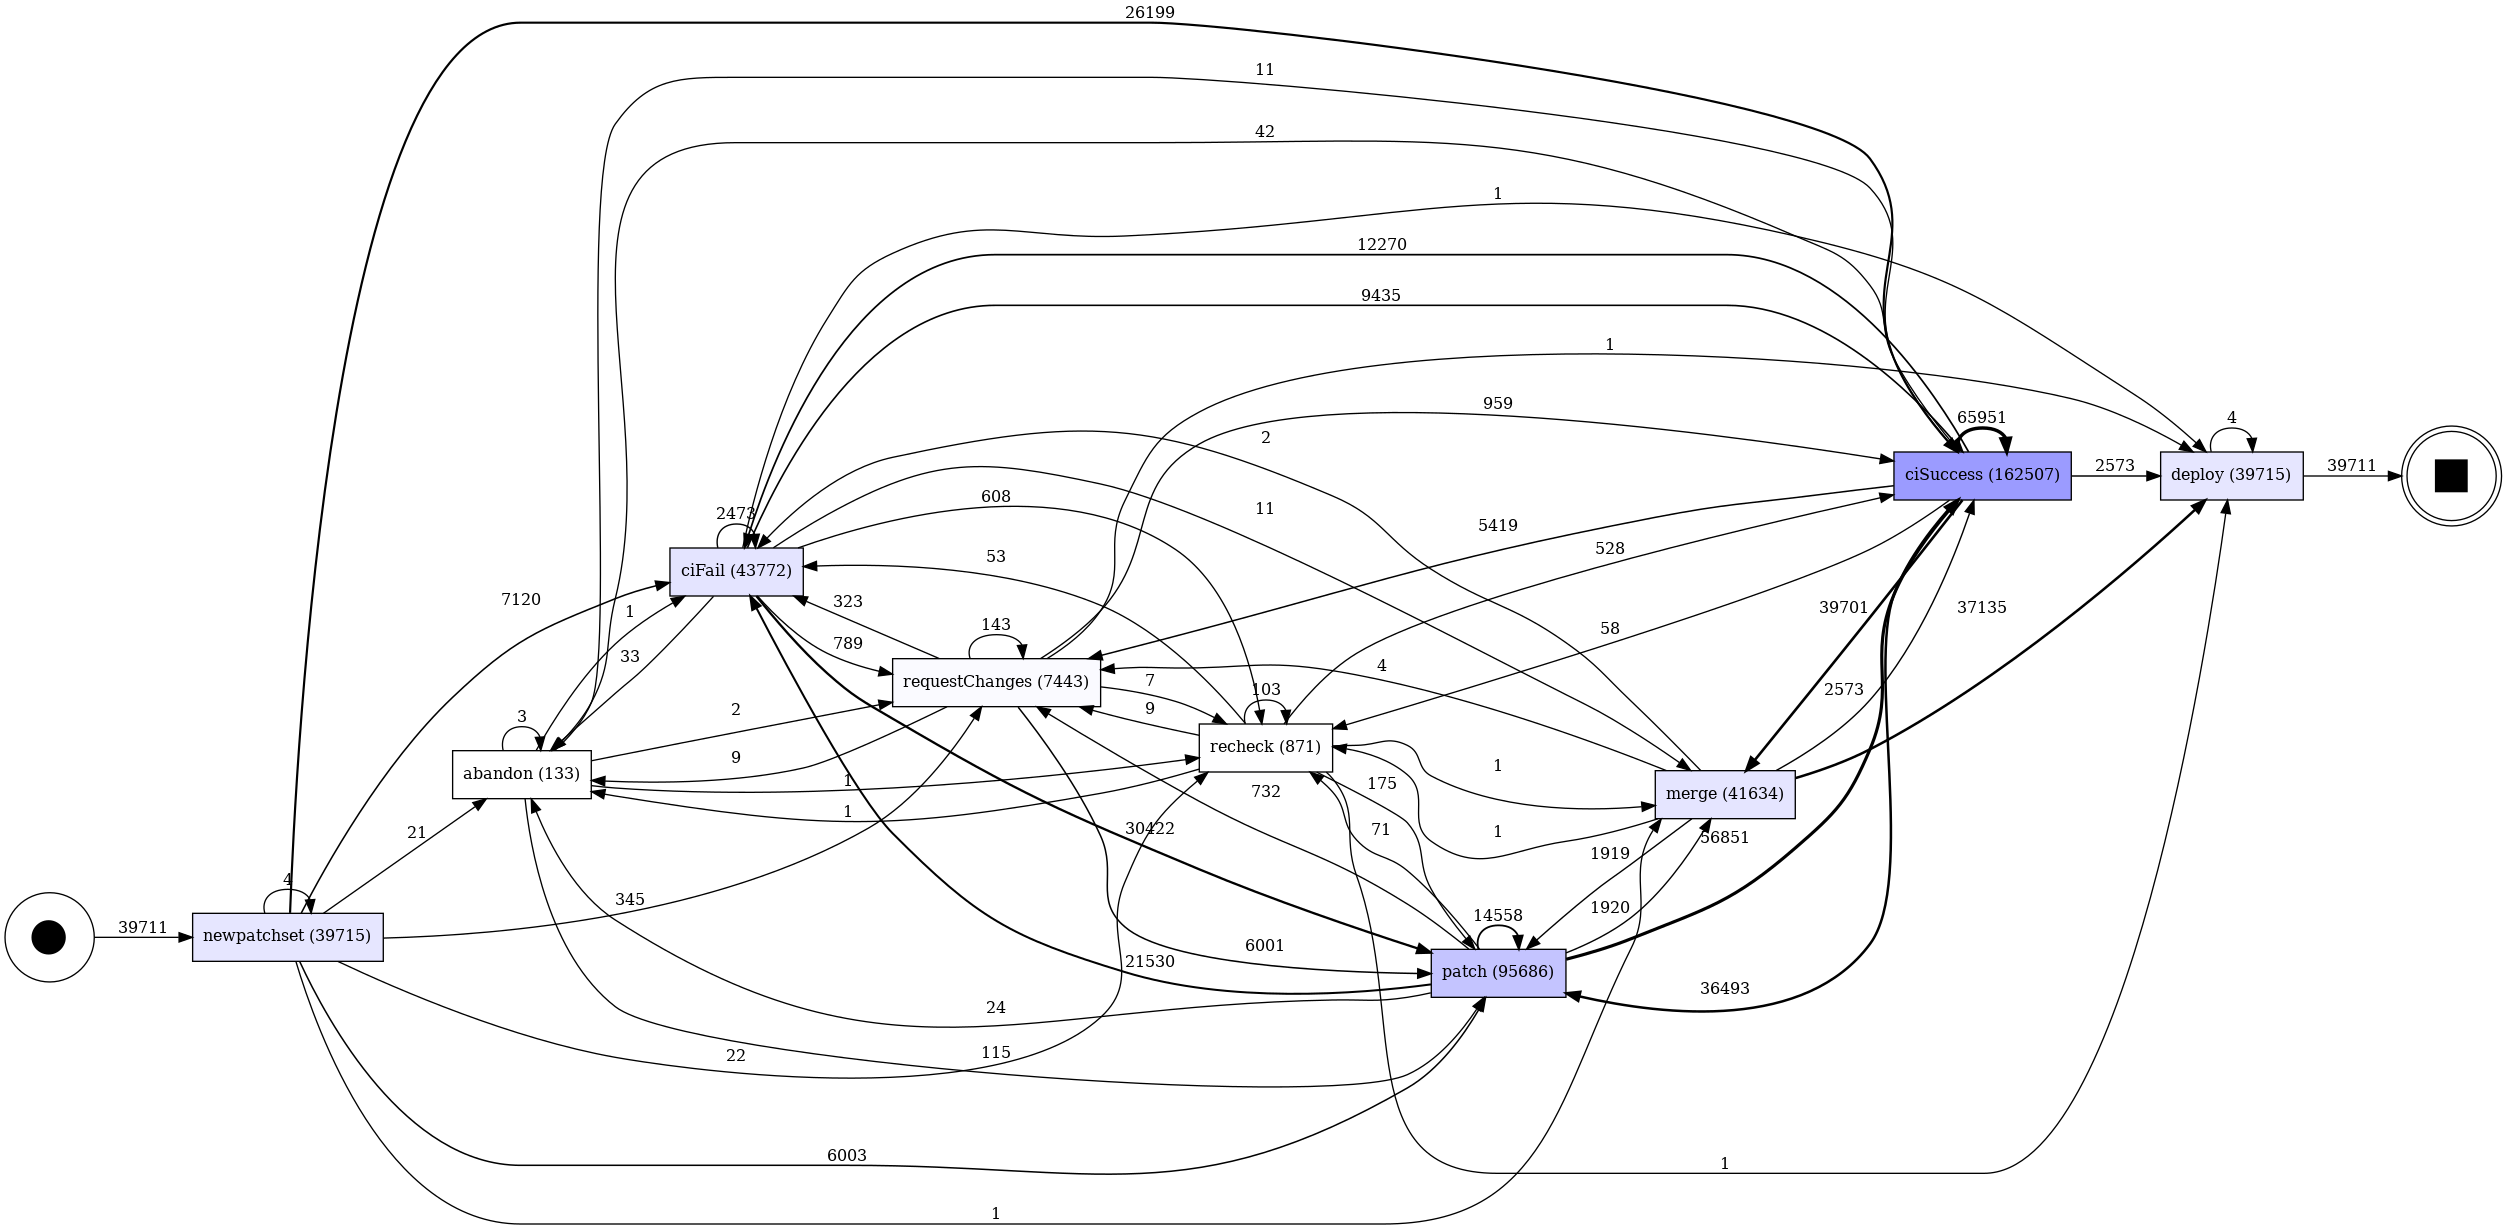

In [101]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
dfg, s, e = pm4py.discover_dfg(filtered_log)
pm4py.view_dfg(dfg, s, e)

## Sum of the time between every step for all patchsets

This will be longer the more often a path is taken. Each edge is the sum of `<patchsets taking the path>*<time on the path for the patchset>`

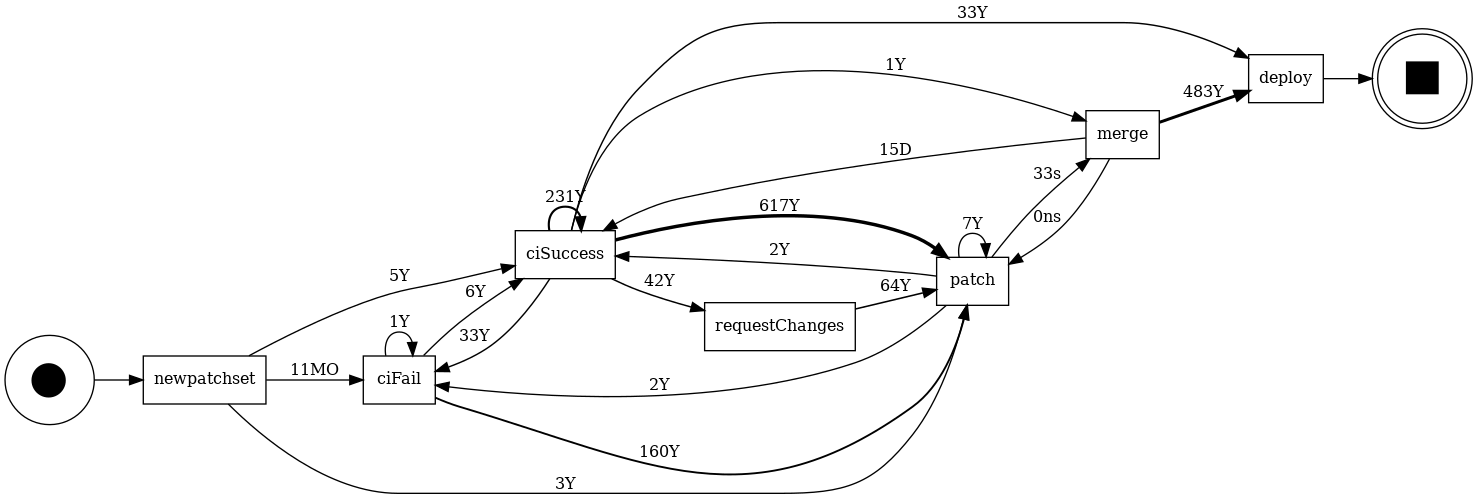

In [103]:
# Discover frequency-based and performance-based DFGs
dfg, s, e = pm4py.discover_dfg(filtered_log)
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(filtered_log)
removal_list = []
# Remove infrequent paths
for e in dfg.items():
  if (e[1]<1000):
    removal_list.append(e[0])
for edge in removal_list:
    if edge in performance_dfg:
        del performance_dfg[edge]
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities, aggregation_measure='sum')

## Average time between each step for every patchset

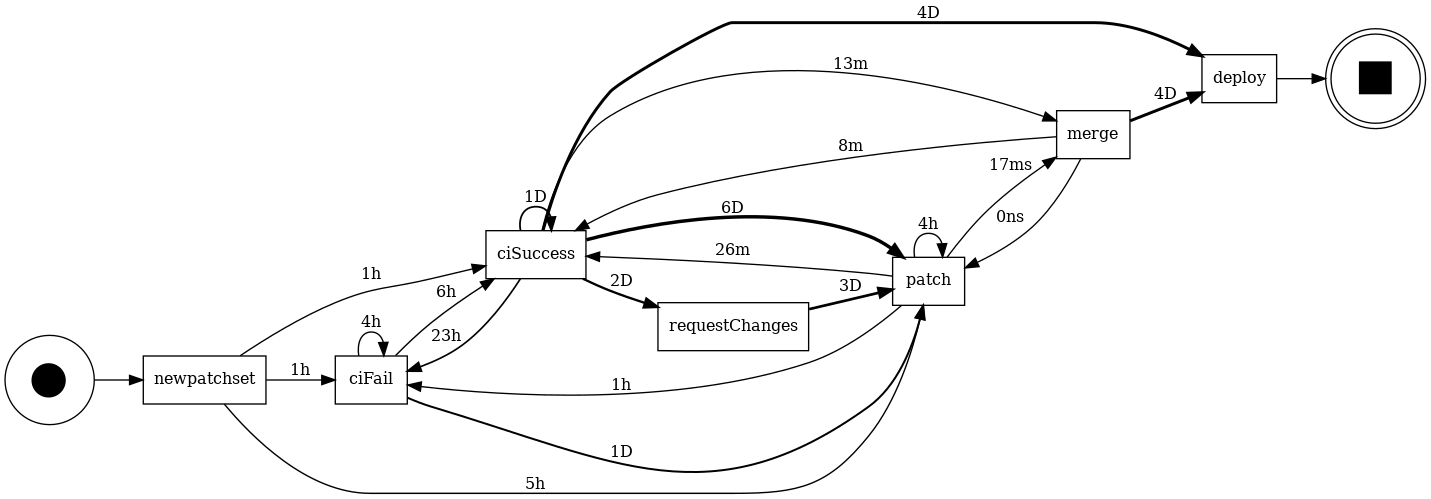

In [104]:
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities, aggregation_measure='mean')